### 1. Summary of the Dataset

In [1]:
import pandas as pd
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_10sec.csv')

print(df.describe())

        Attention      NumFix    AvgFixDur    NumBlink   AvgBlinkDur  \
count  816.000000  816.000000   816.000000  816.000000    816.000000   
mean     0.563725   21.397059   278.825159    4.349265    447.942777   
std      0.496227    7.268332   102.412829    3.068434   1360.222989   
min      0.000000    0.000000     0.000000    0.000000      0.000000   
25%      0.000000   19.000000   226.328577    2.000000    119.270833   
50%      1.000000   23.000000   271.816976    4.000000    172.222222   
75%      1.000000   26.000000   324.671053    6.000000    267.083333   
max      1.000000   40.000000  1139.583333   23.000000  10000.000000   

        AvgPupDia   VarPupDia  OffStimFram   AvgSacAmp  AvgFixDisp  \
count  803.000000  803.000000   816.000000  816.000000  816.000000   
mean     3.602943    0.116902     8.176471    6.335566    0.184728   
std      0.612682    0.095663    17.331223    2.630241    0.063369   
min      1.939376    0.000000     0.000000    0.000000    0.000000   
2

### 2. Identify the best window size using the random forest model

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Load CSV files into DataFrames
window_sizes = [5 * i for i in range(1, 10)]
dataframes = [pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{w}sec.csv") for w in window_sizes]

# Function to split data by participant
def split_by_participant(df, test_size=0.2, random_state=None):
    participants = df['Participant'].unique()
    train_participants, test_participants = train_test_split(participants, test_size=test_size, random_state=random_state)
    
    train_df = df[df['Participant'].isin(train_participants)]
    test_df = df[df['Participant'].isin(test_participants)]
    
    X_train = train_df[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
    y_train = train_df['Attention']
    X_test = test_df[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
    y_test = test_df['Attention']
    
    return X_train, X_test, y_train, y_test

# Number of iterations
iterations = 30

# Loop through each DataFrame and random states
results = {w: [] for w in window_sizes}
for random_state in range(iterations):
    for w, df in zip(window_sizes, dataframes):
        # Split data by participant
        X_train, X_test, y_train, y_test = split_by_participant(df, test_size=0.2, random_state=random_state)
        
        # Initialize and train classifier
        clf = RandomForestClassifier(random_state=random_state)
        clf.fit(X_train, y_train)
        
        # Make predictions and evaluate performance
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store accuracy
        results[w].append(accuracy)

# Calculate average accuracy for each window size
average_results = {w: np.mean(acc) for w, acc in results.items()}

# Print results
for w, avg_acc in average_results.items():
    print(f"Window size: {w} sec, Average accuracy: {avg_acc:.2f}")

# Find the best window size
best_window = max(average_results, key=average_results.get)
print(f"Best window size: {best_window} sec with average accuracy: {average_results[best_window]:.2f}")


Window size: 5 sec, Average accuracy: 0.53
Window size: 10 sec, Average accuracy: 0.55
Window size: 15 sec, Average accuracy: 0.57
Window size: 20 sec, Average accuracy: 0.59
Window size: 25 sec, Average accuracy: 0.61
Window size: 30 sec, Average accuracy: 0.61
Window size: 35 sec, Average accuracy: 0.61
Window size: 40 sec, Average accuracy: 0.62
Window size: 45 sec, Average accuracy: 0.62
Best window size: 40 sec with average accuracy: 0.62


#### 2.1 Use the Logit Regression model to statistically identify how many features are relevant to the mind wandering

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_25sec.csv')

# Convert 'Attention' to integer type
df['Attention'] = df['Attention'].astype(int)

# Define the predictor variables (X) and the target variable (y)
X = df[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
y = df['Attention']

# Check for missing or infinite values and drop rows with such values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y[X.index]  # Ensure that y matches the indices of X after dropping

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit a logistic regression model
logit_model = sm.Logit(y, X).fit()

# Summarize the results
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.626255
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Attention   No. Observations:                  813
Model:                          Logit   Df Residuals:                      801
Method:                           MLE   Df Model:                           11
Date:                Wed, 15 May 2024   Pseudo R-squ.:                 0.08547
Time:                        17:45:15   Log-Likelihood:                -509.15
converged:                       True   LL-Null:                       -556.73
Covariance Type:            nonrobust   LLR p-value:                 1.609e-15
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.9017      1.048      0.861      0.389      -1.152       2.955
NumFix           

**Summary**
- The best window size (25) yielded a mean CV score of 0.57.
- Significant predictors of mind wandering are NumFix, NumBlink, and VarPupDia.
- The logistic regression model's Pseudo R-squ. value (0.06497) is relatively low, suggesting that while these predictors provide some explanation, additional or more accurate features may further improve the model.

**Next Steps**
- Investigate additional predictors or other window sizes.
- Consider cross-validation or other statistical tests to ensure robustness.
- Explore alternative models to compare predictive performance.

#### 2.2 Correlation Heatmap of extracted features

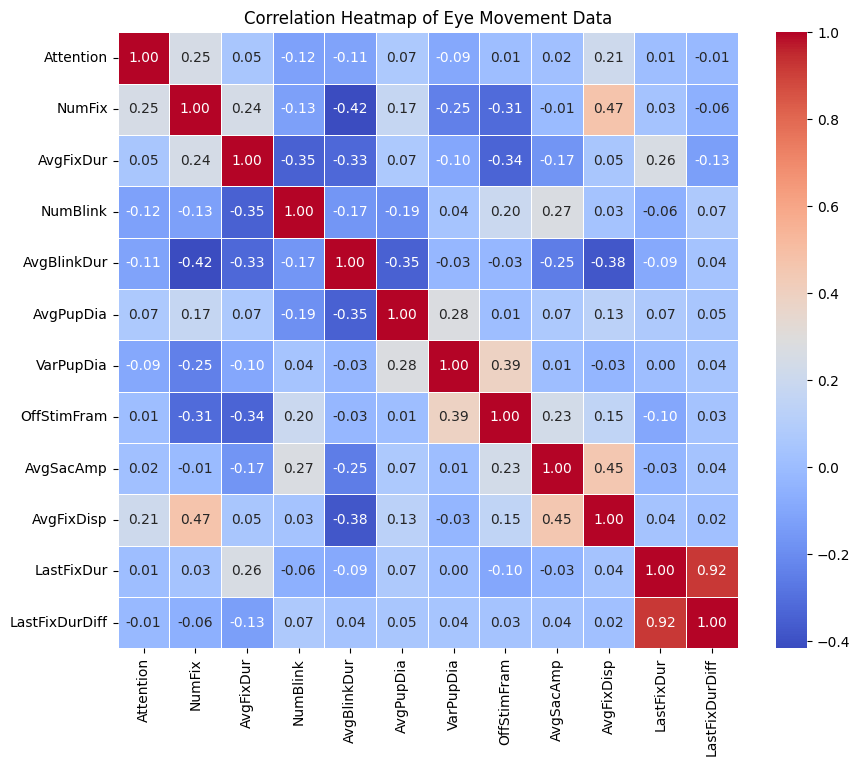

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_25sec.csv')
X = df[['Attention', 'NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram', 'AvgSacAmp', 'AvgFixDisp', 'LastFixDur', 'LastFixDurDiff']]
# Compute correlation matrix
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap of Eye Movement Data")
plt.show()

#### 2.3 ANOVA
- If you're interested in differences between groups (e.g., different stimuli), ANOVA can help determine if there are statistically significant differences in eye movement parameters across different levels of attention.

In [8]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load your data
data = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_5sec.csv')  # Update the path to your CSV file

# List of variables to analyze
variables = ['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram']

# Dictionary to store ANOVA results
anova_results = {}

# Perform ANOVA for each variable across different stimuli
for var in variables:
    model = ols(f'{var} ~ C(Stimuli)', data=data).fit()
    anova_results[var] = sm.stats.anova_lm(model, typ=2)  # Using Type II sum of squares

# Print the ANOVA results for each variable
for var, result in anova_results.items():
    print(f"ANOVA Results for {var}:")
    print(result)
    print("\n")


ANOVA Results for NumFix:
                 sum_sq     df         F    PR(>F)
C(Stimuli)   213.409722   23.0  0.802219  0.730262
Residual    6384.583333  552.0       NaN       NaN


ANOVA Results for AvgFixDur:
                   sum_sq     df         F    PR(>F)
C(Stimuli)    6654.318383   23.0  0.687748  0.859909
Residual    232212.340775  552.0       NaN       NaN


ANOVA Results for NumBlink:
                 sum_sq     df         F   PR(>F)
C(Stimuli)    47.234375   23.0  0.602311  0.92855
Residual    1882.125000  552.0       NaN      NaN


ANOVA Results for AvgBlinkDur:
                   sum_sq     df         F    PR(>F)
C(Stimuli)    7601.350770   23.0  0.876869  0.630875
Residual    208049.734896  552.0       NaN       NaN


ANOVA Results for AvgPupDia:
                sum_sq     df         F    PR(>F)
C(Stimuli)    4.224863   23.0  0.412879  0.993522
Residual    245.584875  552.0       NaN       NaN


ANOVA Results for VarPupDia:
              sum_sq     df         F    PR(>F)

- Interpretation of ANOVA Results:
    - p-values: All p-values are well above the typical significance level (usually 0.05). This implies that the null hypothesis (no difference in eye movement parameters across different stimuli) cannot be rejected for any of the parameters you analyzed.
    - F-statistic: The F-values are relatively low, which supports the lack of statistically significant differences across groups.

5 [0.5775862068965517, 0.5344827586206896, 0.5603448275862069, 0.5948275862068966, 0.5, 0.5086206896551724, 0.5689655172413793, 0.5948275862068966, 0.5086206896551724, 0.5775862068965517, 0.5862068965517241, 0.5603448275862069, 0.5517241379310345, 0.5258620689655172, 0.5, 0.5172413793103449, 0.5689655172413793, 0.5344827586206896, 0.6379310344827587, 0.6379310344827587, 0.5258620689655172, 0.5431034482758621, 0.6293103448275862, 0.5344827586206896, 0.5948275862068966, 0.6206896551724138, 0.5258620689655172, 0.5431034482758621, 0.5948275862068966, 0.5172413793103449, 0.5775862068965517, 0.6379310344827587, 0.5689655172413793, 0.5172413793103449, 0.6293103448275862, 0.6206896551724138, 0.5603448275862069, 0.5431034482758621, 0.5862068965517241, 0.5258620689655172, 0.5775862068965517, 0.6120689655172413, 0.5603448275862069, 0.5862068965517241, 0.5, 0.5517241379310345, 0.5172413793103449, 0.5603448275862069, 0.5775862068965517, 0.5]
10 [0.5344827586206896, 0.5517241379310345, 0.61206896551

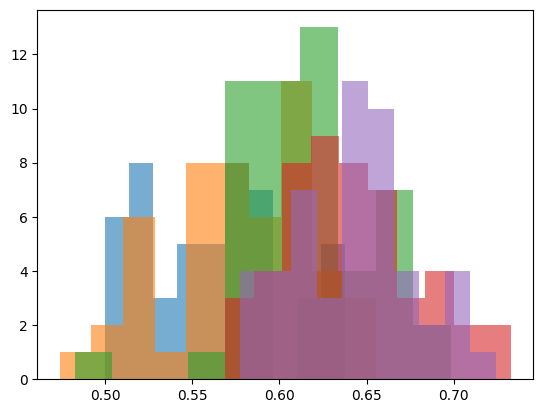

In [32]:
import pandas as pd
import statistics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load CSV files into DataFrames
window_sizes = [5, 10, 15, 20, 25]
dataframes = [pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{w}sec.csv") for w in window_sizes]

# Loop through each DataFrame
all_accuracies = {w: [] for w in window_sizes}

for state in range(50):  # Loop through 20 random states
    for w, df in zip(window_sizes, dataframes):
        # Extract features and labels
        X = df[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram']]
        y = df['Attention']

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Initialize and train classifier
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)

        # Evaluate accuracy
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # Store accuracy
        all_accuracies[w].append(accuracy)

# Calculate the average accuracy and variance for each window size
for w, acc in all_accuracies.items():
    print(w, acc)
    
average_accuracies = []
for w, accuracies in all_accuracies.items():
    avg_accuracy = sum(accuracies) / len(accuracies)
    stdev_accuracy = statistics.stdev(accuracies)
    average_accuracies.append({'window': w, 'average_accuracy': avg_accuracy, 'stdev_accuracy': stdev_accuracy})

# Print the average accuracy and variance for each window size
for result in average_accuracies:
    print(f"Window size: {result['window']}, Average Accuracy: {result['average_accuracy']:.4f}, Stdev: {result['stdev_accuracy']:.4f}")


for w, accuracies in all_accuracies.items():
    plt.hist(accuracies, bins=10, alpha=0.6, label=f'Window Size: {w}')